
 CLEANED CUSTOMER DATA (All Rows):
    Customer_ID    Customer_Name Region  Total_Spend  Purchase_Frequency  Marketing_Spend  Seasonality_Index Churned
0           101         John Doe  North         5000                  12             2000                1.2      No
1           102       Jane Smith  South         3000                   8             1500                1.0     Yes
2           103        Sam Brown   East         4500                  10             1800                1.1      No
3           104    Linda Johnson   West         2500                   5             1000                0.9     Yes
4           105      Michael Lee  North         7000                  15             2500                1.3      No
5           106      Emily Davis  South         3200                   7             1400                1.0     Yes
6           107     David Wilson   East         5300                  14             2300                1.2      No
7           108      Susan W

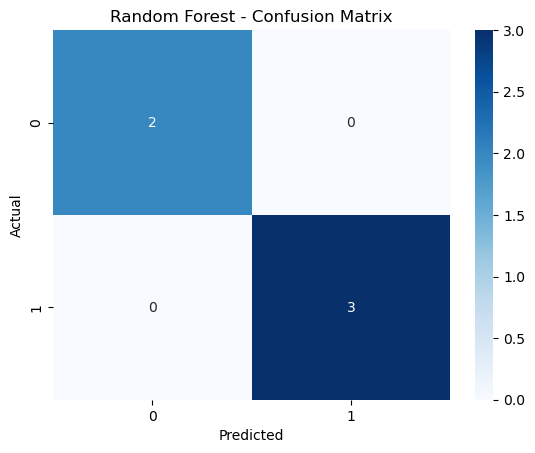


=== XGBoost Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



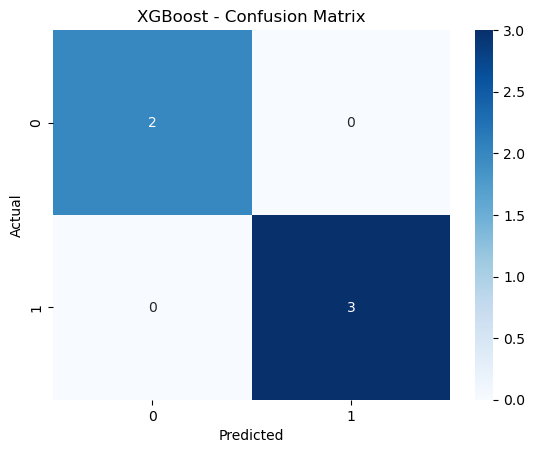

 Best RF Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
 Best XGB Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}


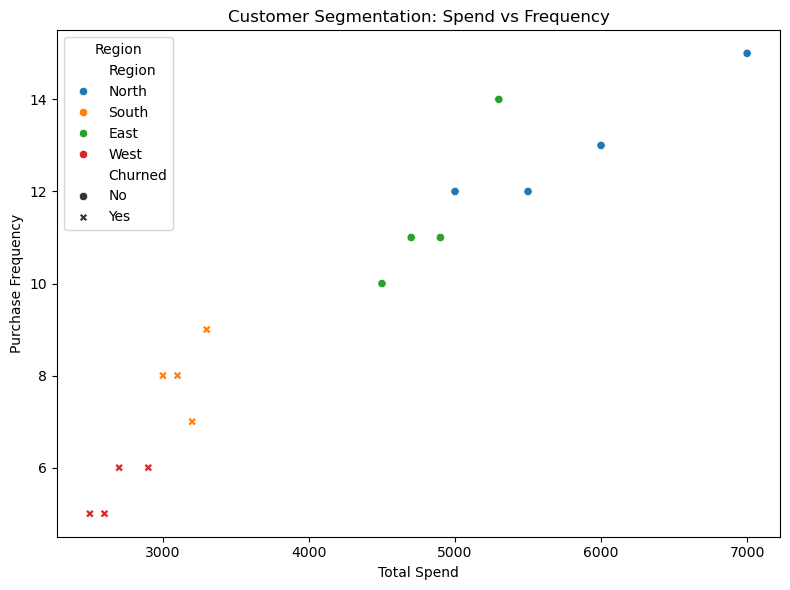

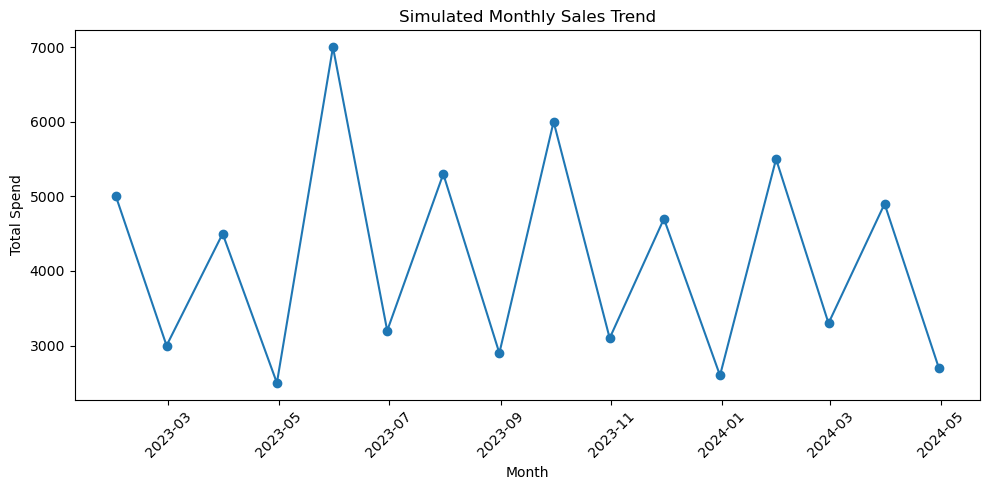

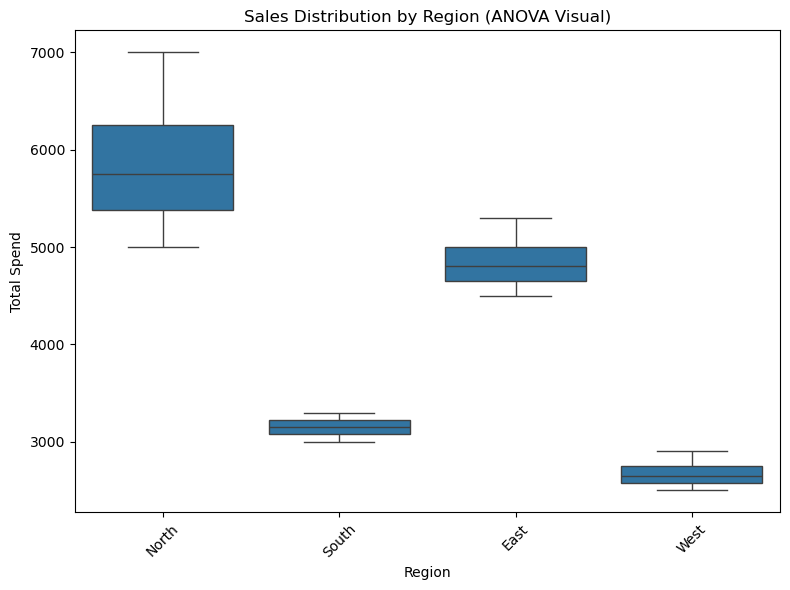

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# === DISPLAY SETTINGS ===
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)  # ✅ SHOW ALL ROWS
pd.set_option('display.width', 1200)

# === LOAD FULL CLEANED DATA ===
df = pd.read_csv(r"C:\Users\angel\OneDrive\Desktop\raw_sales_data.csv")

# === BACKUP FOR DISPLAY ===
df_display = df.copy()

# === ENCODING ===
le_churn = LabelEncoder()
df['Churned'] = le_churn.fit_transform(df['Churned'])  # Yes = 1, No = 0

le_region = LabelEncoder()
df['Region_encoded'] = le_region.fit_transform(df['Region'])  # Keep original for plots

# === CLEANED DATA PREVIEW ===
print("\n CLEANED CUSTOMER DATA (All Rows):")
print(df_display)

# === SUMMARY STATS (HORIZONTAL) ===
stats_df = pd.DataFrame({
    'Mean': df.select_dtypes(include='number').mean(),
    'Median': df.select_dtypes(include='number').median(),
    'Mode': df.select_dtypes(include='number').mode().iloc[0],
    'Standard Deviation': df.select_dtypes(include='number').std()
}).T.round(2)

print("\n SUMMARY STATISTICS (Horizontal):")
print(stats_df.to_string())

# === FEATURE/TARGET SPLIT FOR MODELING ===
X = df[['Total_Spend', 'Purchase_Frequency', 'Marketing_Spend', 'Seasonality_Index']]
y = df['Churned']
X_scaled = StandardScaler().fit_transform(X)

# === TRAIN-TEST SPLIT ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42)

# === RANDOM FOREST MODEL ===
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
rf_grid.fit(X_train, y_train)
rf_preds = rf_grid.best_estimator_.predict(X_test)

# === XGBOOST MODEL ===
xgb_params = {
    'n_estimators': [50, 100],
    'max_depth': [3, 4],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}
xgb_grid = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    xgb_params,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
xgb_grid.fit(X_train, y_train)
xgb_preds = xgb_grid.best_estimator_.predict(X_test)

# === EVALUATION FUNCTION ===
def evaluate_model(name, y_true, y_pred):
    print(f"\n=== {name} Classification Report ===")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# === MODEL EVALUATION ===
evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("XGBoost", y_test, xgb_preds)

print(" Best RF Params:", rf_grid.best_params_)
print(" Best XGB Params:", xgb_grid.best_params_)

# === VISUALIZATION 1: Customer Segmentation ===
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_display,
    x='Total_Spend',
    y='Purchase_Frequency',
    hue='Region',
    style='Churned',
    palette='tab10'
)
plt.title("Customer Segmentation: Spend vs Frequency")
plt.xlabel("Total Spend")
plt.ylabel("Purchase Frequency")
plt.legend(title="Region")
plt.tight_layout()
plt.show()

# === VISUALIZATION 2: Simulated Time Series ===
df_time = df_display.copy()
df_time['Month'] = pd.date_range(start='2023-01-01', periods=len(df_time), freq='M')
df_time = df_time.sort_values(by='Month')

plt.figure(figsize=(10, 5))
plt.plot(df_time['Month'], df_time['Total_Spend'], marker='o')
plt.title("Simulated Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Spend")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === VISUALIZATION 3: ANOVA Boxplot ===
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_display, x='Region', y='Total_Spend')
plt.title("Sales Distribution by Region (ANOVA Visual)")
plt.xlabel("Region")
plt.ylabel("Total Spend")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:
df.to_csv("cleaned_customer_data.csv", index=False)
print(" Cleaned dataset exported as 'cleaned_customer_data.csv'")


 Cleaned dataset exported as 'cleaned_customer_data.csv'
